In [77]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
import nltk.corpus
import nltk.tokenize
import string
import gensim
from gensim.models import FastText

from os import listdir
from os.path import isfile, join

import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model, BertTokenizer, BertModel
import torchaudio
import librosa

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from transformers import logging
logging.set_verbosity_error()

In [2]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)
print(device)

cuda:0


In [130]:
def save_file(path, arr):
    with open(path, 'wb') as f:
        np.save(f, arr)
    return

def load_file(path):
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

def labels_7(a):
    if a < -2:
        res = -3
    if -2 <= a and a < -1:
        res = -2
    if -1 <= a and a < 0:
        res = -1
    if 0 <= a and a <= 0:
        res = 0
    if 0 < a and a <= 1:
        res = 1
    if 1 < a and a <= 2:
        res = 2
    if a > 2:
        res = 3
    return res

def labels_2(nums):
    if nums > 0:
        return 1
    return -1

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    words = [token.lower() for token in tokens if token not in punctuations]
    return words

def word_mean(model, words):
    mean = []
    for word in words:
        mean.append(model.wv[word])
    if not mean:
        return np.zeros(model.vector_size)
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean


def word_mean_list(model, text):
    return np.vstack([word_mean(model, line) for line in text])


def visualization_2D(data, method, label_2=df.sentiment_2, label_7=df.sentiment_7):
    
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    if method == 'PCA':
        reduced_data = PCA(n_components=2).fit_transform(data)
    else:
        reduced_data = TSNE(n_components=2).fit_transform(data)

    ax[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=label_2)
    ax[0].set_title('Распределение метки (2 класса)')

    ax[1].scatter(reduced_data[:, 0], reduced_data[:, 1], c=label_7)
    ax[1].set_title('Распределение метки (7 клссов)')
    
    return


def visualization_3D(data, method, label_2=df.sentiment_2, label_7=df.sentiment_7):
    
    fig = plt.figure(figsize=(15, 5))
    
    if method == 'PCA':
        reduced_data = PCA(n_components=3).fit_transform(data)
    else:
        reduced_data = TSNE(n_components=3).fit_transform(data)
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=label_2)
    ax.set_title('Распределение метки (2 класса)')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=label_7)
    ax.set_title('Распределение метки (2 класса)')
    
    return


def visualization_acustics(file, sr=16_000):
    
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    audio, sr = librosa.load(file, sr=16_000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr)
    melspec = librosa.feature.melspectrogram(y=audio, sr=sr)
    
    librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max), x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set_title('mel spec')
    librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
    ax[1].set_title('mfccs')
    
    return


punctuations = list(string.punctuation)
punkt = ['``','...',"''",'«','»','…','”','”','“','-','–','..']
punctuations.extend(punkt)

In [4]:
all_df = pd.read_csv('Labels-20230327T191554Z-001/Labels/Data_Train_modified.csv')
all_df.head()

video  start_time  end_time  sentiment     happy       sad  anger  \
0  -3g5yACwYnA     82.7645  100.5550   1.000000  0.666667  0.666667    0.0   
1  -3g5yACwYnA    119.9190  125.2990   0.666667  0.000000  0.000000    0.0   
2  -3g5yACwYnA      4.8400   13.6315   0.000000  0.666667  0.666667    0.0   
3  -3g5yACwYnA     13.6315   27.0310   0.000000  0.333333  0.333333    0.0   
4  -3g5yACwYnA     27.0310   41.3000   1.000000  0.666667  0.000000    0.0   

   surprise  disgust      fear  \
0       0.0      0.0  0.666667   
1       0.0      0.0  0.000000   
2       0.0      0.0  0.333333   
3       0.0      0.0  0.000000   
4       0.0      0.0  0.000000   

                                                text  \
0  Key is part of the people that we use to solve...   
1  They've been able to find solutions or at leas...   
2  Key Polymer brings a technical aspect to our o...   
3  We're a huge user of adhesives for our operati...   
4  Key brings those types of aspects to a busines...   

                                                 ASR  
0   key part of the people that we use the to sel...  
1   is that we do they have been able to find sol...  
2   creations and key brings a keep our brains ar...  
3   we are a huge a user of adhesives for our ope...  
4   he brings those types of a aspects to our bus...

In [5]:
df = pd.read_csv('Labels-20230327T191554Z-001/Labels/Data_Train_modified.csv')
df = df[['ASR', 'sentiment'][::-1]]
df.head()

sentiment                                                ASR
0   1.000000   key part of the people that we use the to sel...
1   0.666667   is that we do they have been able to find sol...
2   0.000000   creations and key brings a keep our brains ar...
3   0.000000   we are a huge a user of adhesives for our ope...
4   1.000000   he brings those types of a aspects to our bus...

In [6]:
df['sentiment_7'] = df.sentiment.apply(labels_7)
df['sentiment_2'] = df.sentiment.apply(labels_2)

In [7]:
df.sentiment_7.value_counts()

 1    5269
 0    3521
-1    2535
 2    2248
-2    1584
-3     613
 3     504
Name: sentiment_7, dtype: int64

In [8]:
df.sentiment_2.value_counts()

-1    8253
 1    8021
Name: sentiment_2, dtype: int64

**В данной** `работе рассматривается задача предсказания тональности по исходному тексту и акустической информации.
Для этого исходные оценки тональности представлены двумя и семью классами.`

### Bar-plot classes

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16274 entries, 0 to 16273
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentiment    16274 non-null  float64
 1   ASR          16274 non-null  object 
 2   sentiment_7  16274 non-null  int64  
 3   sentiment_2  16274 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 508.7+ KB


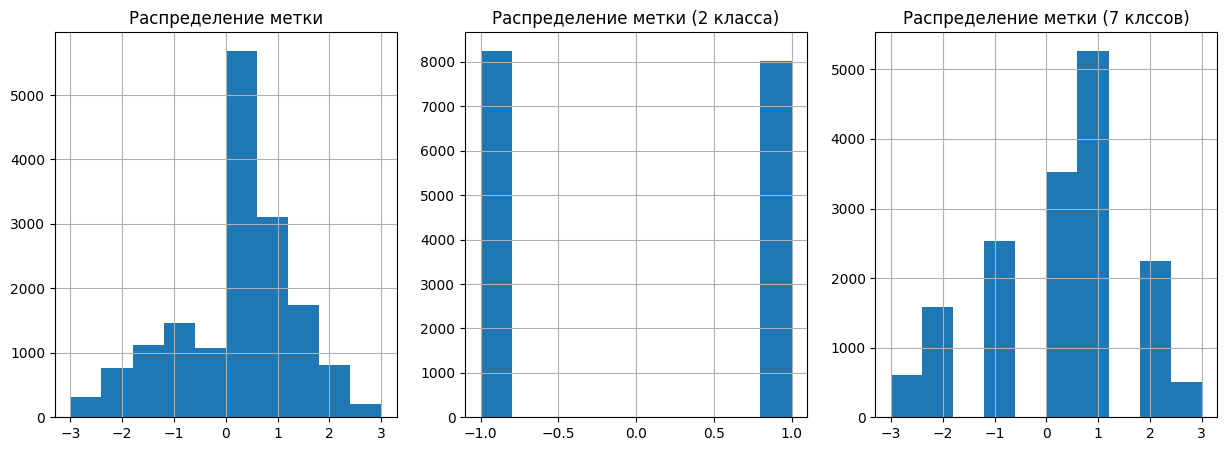

In [64]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

df.sentiment.hist(ax=ax[0])
ax[0].set_title('Распределение метки')

df.sentiment_2.hist(ax=ax[1])
ax[1].set_title('Распределение метки (2 класса)')

df.sentiment_7.hist(ax=ax[2])
ax[2].set_title('Распределение метки (7 клссов)');

**Выводы:** `по гистограммам распределения меток видно, что в случае двух-классовой классификации набор данных можно считать сбалансированным. Однако в случае семи классов набор не сбалансирован, поэтому могут быть проблемы выучивания и репрезентативности классов при обучении. Дисбаланс вероятно связан с тем, что в жизни трудно собрать данные с действительно яркой эмоционально окрашенной лексикой.`

### Text feature extraction: FASTTEXT

**Представим** `слова из набора данных в виде векторов, которые в какой-то мере сохранаяют в себе семантическую информацию. Для этого выберем модель FasText, который работает на n-граммах хорошо подходит для морфологически богатых языков, таких как русский. После этого визуализируем полученные эмбеддинги с помощью PCA и TSNE (моделирует низкоразмерные точки так, что схожие объекты сохраняют близость)`

In [10]:
text = df.ASR
text = [tokenize(line) for line in text]

fasttext_model = FastText(sentences=text, vector_size=500, window=10, min_count=1, workers=4)
fasttext_model.build_vocab(text)
fasttext_model.train(text, total_examples=fasttext_model.corpus_count, epochs=1000, report_delay=1)
fasttext_model.init_sims(replace=True)
text = word_mean_list(fasttext_model, text)

In [11]:
print(f'{text.shape=}')

text.shape=(16274, 500)


In [12]:
save_file('saved/fasttext_train.npy', text)

In [70]:
text = load_file('saved/fasttext_train.npy')

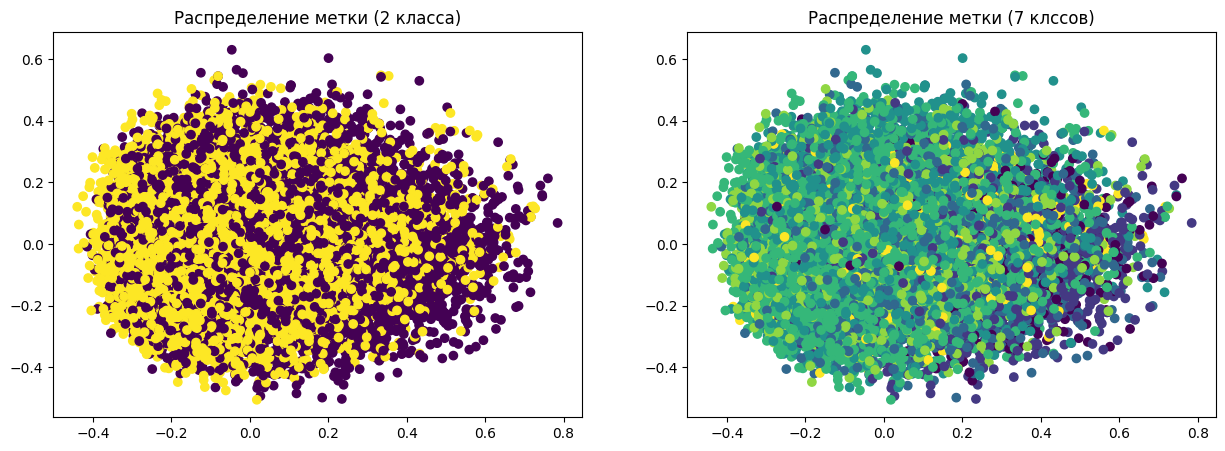

In [79]:
visualization_2D(text, 'PCA')

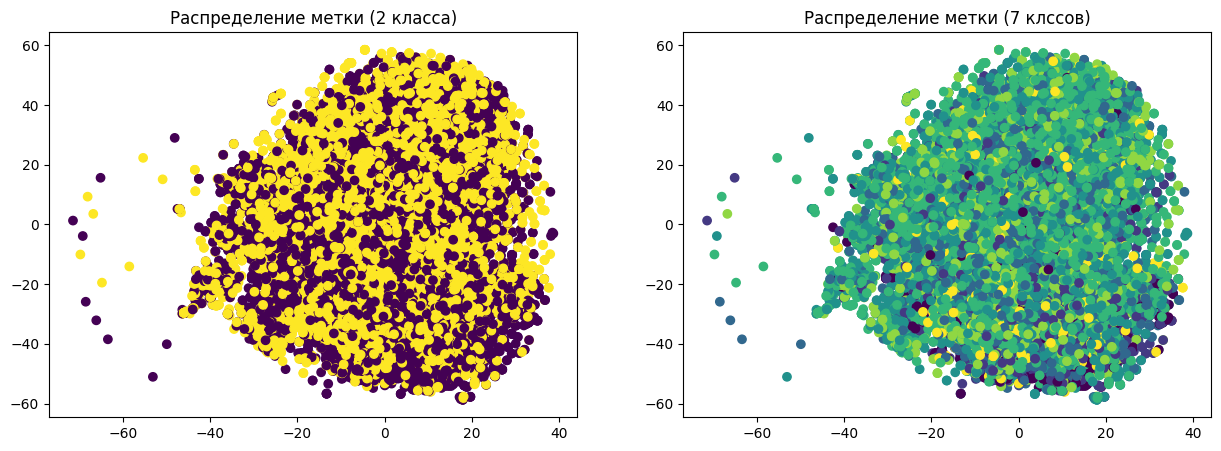

In [80]:
visualization_2D(text, 'TSNE')

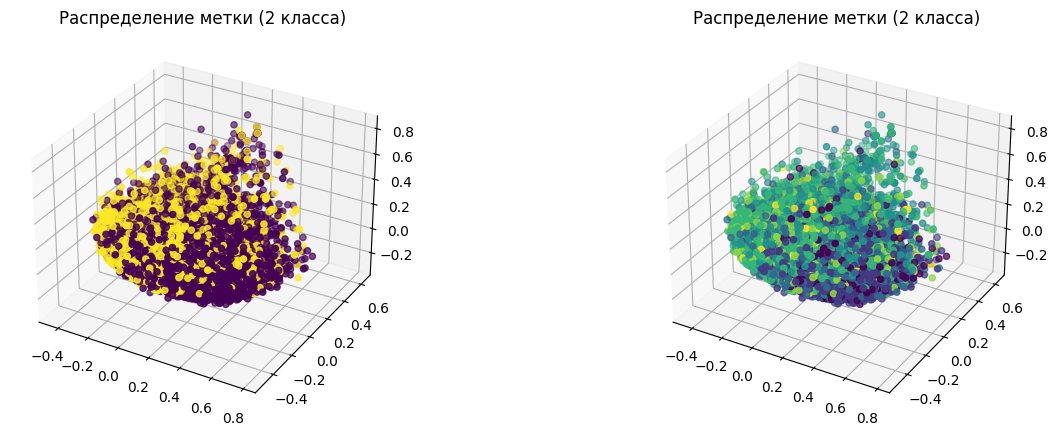

In [82]:
visualization_3D(text, 'PCA')

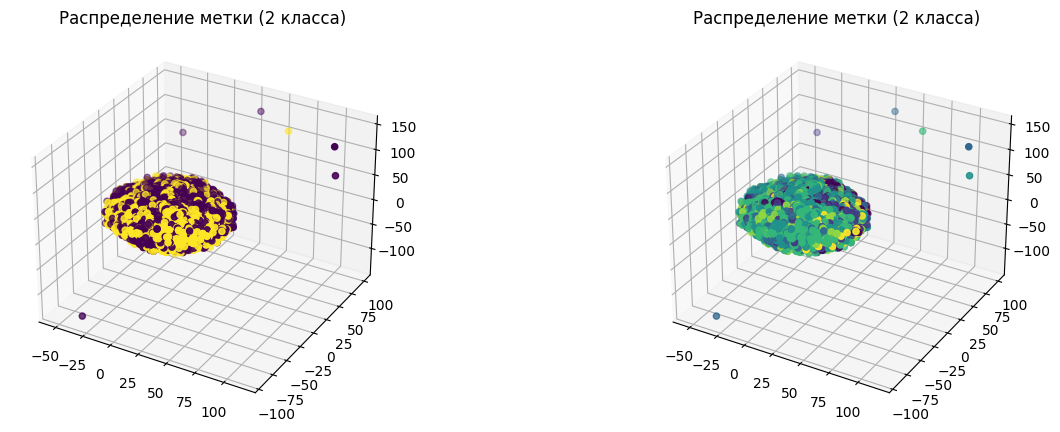

In [83]:
visualization_3D(text, 'TSNE')

**Выводы:** `визулизация с помощью PCA и TSNE не выявила никакие паттерны в классах`

### Text feature extraction: BERT

**Попробуем** `получить эмбеддинги с помощью стека кодеров Transformer, использующих механизм внимания для языкового моделирования и учета контекста (BERT).`

In [29]:
model_id = 'prajjwal1/bert-tiny'

tokenizer = BertTokenizer.from_pretrained(model_id)
model = BertModel.from_pretrained(model_id).to(device)

_output = []
for t in df.ASR.values:
    text = t
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    last_hidden_states = output.last_hidden_state.squeeze().mean(axis=0).cpu().numpy()
    _output.append(last_hidden_states)

In [30]:
_output = np.array(_output)

In [31]:
print(f'{_output.shape=}')

_output.shape=(16274, 128)


In [32]:
save_file('saved/bert_train.npy', _output)

In [85]:
text = load_file('saved/bert_train.npy')

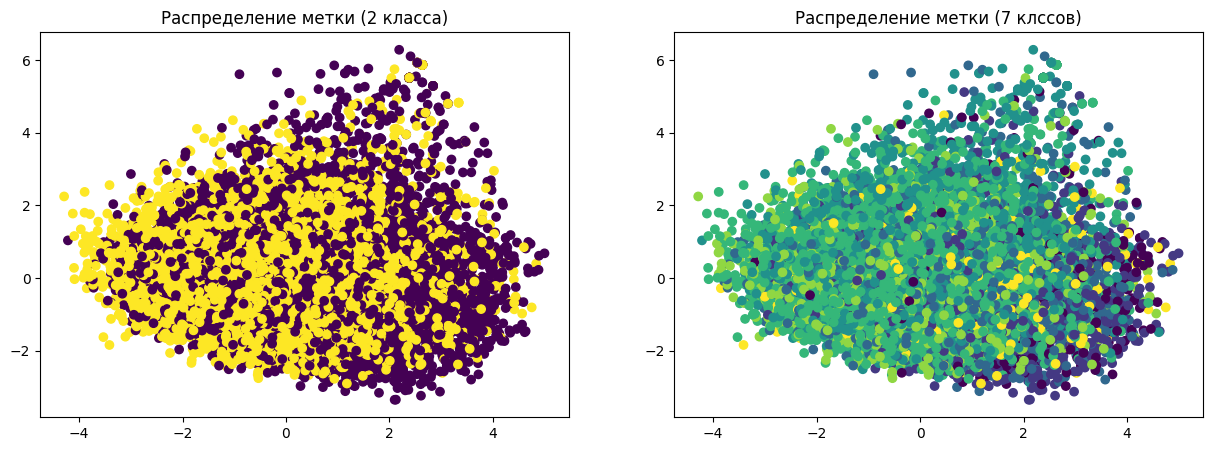

In [86]:
visualization_2D(text, 'PCA')

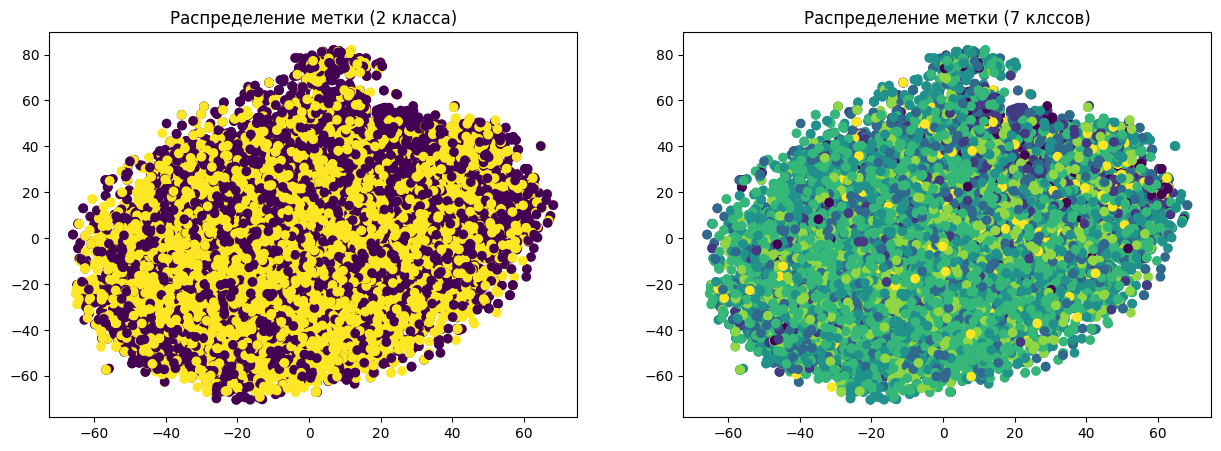

In [87]:
visualization_2D(text, 'TSNE')

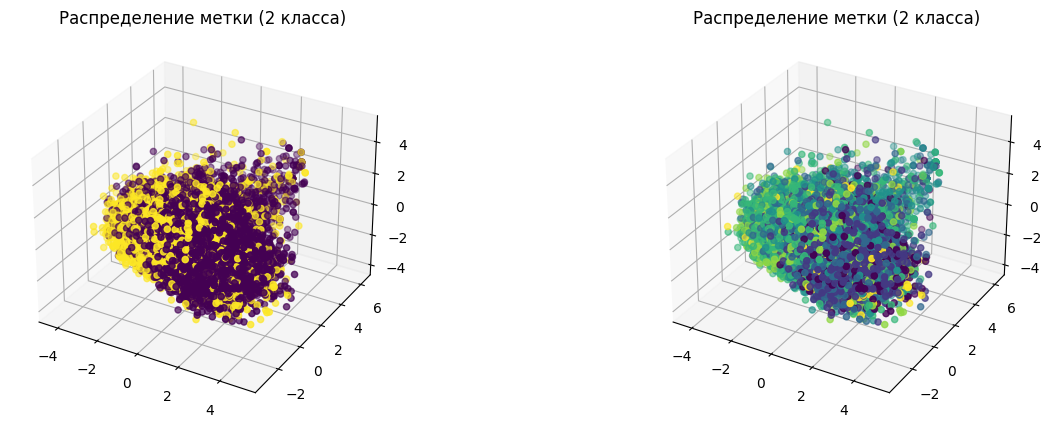

In [88]:
visualization_3D(text, 'PCA')

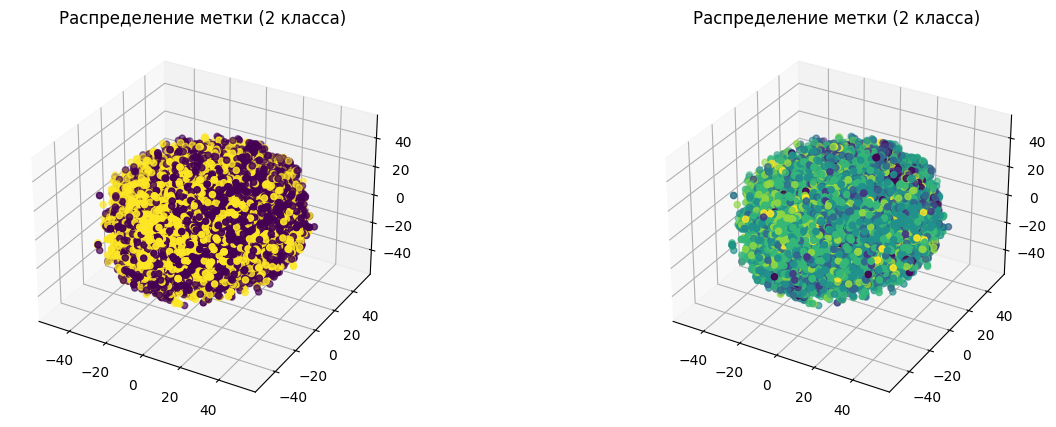

In [89]:
visualization_3D(text, 'TSNE')

**Выводы:** `визулизация с помощью PCA и TSNE не выявила никакие паттерны в классах. Возможно, можно получить лучшее представление после fine-tuning`

### Audio feature extraction: WAV2VEC

**Воспользуемся** `подходом wav2vec для получения эмбеддингов wav-файлов (две предобученных моделей 'patrickvonplaten/wav2vec2_tiny_random' и 'ybelkada/tiny-wav2vec2-stable-ln').`

`Данный подход ипользуется в распознаваниии речи и не требует транскрибированных данных.`

In [38]:
# const = 10_000
# v_name, start_time, end_time = 'ZQaGGpcIPHM_12.9920_17.5540.wav'[:-4].split('_')
# start_time, end_time = float(start_time), float(end_time)
# all_df[(all_df.start_time * const == start_time * const) & (all_df.end_time * const == end_time * const)]

In [39]:
path_ = './Train_modified-20230327T210559Z-001/Train_modified/'

In [40]:
onlyfiles = [f for f in listdir(path_) if isfile(join(path_, f))]

In [41]:
all_df['sentiment_7'] = all_df.sentiment.apply(labels_7)
all_df['sentiment_2'] = all_df.sentiment.apply(labels_2)

In [42]:
audio_feats = []
for i, row in all_df[['video', 'start_time', 'end_time']].iterrows():
    file = f"{row['video']}_{row['start_time']:.4f}_{row['end_time']:.4f}.wav"
    if file in onlyfiles:
        audio_feats.append(file)
    else:
        audio_feats.append(pd.NaT)

In [43]:
all_df['audio_feats'] = np.array(audio_feats)

In [44]:
# all_df.head()

In [45]:
all_df.to_csv('saved/dataset_with_audio.csv')

In [23]:
all_df = pd.read_csv('saved/dataset_with_audio.csv')
all_df = all_df.dropna()

In [34]:
model_id = 'patrickvonplaten/wav2vec2_tiny_random'
model_id = 'ybelkada/tiny-wav2vec2-stable-ln'
# model_id = 'facebook/wav2vec2-base'

processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2Model.from_pretrained(model_id).to(device)

path_ = './Train_modified-20230327T210559Z-001/Train_modified/'
_output = []
for f in all_df['audio_feats'].values:
    array, fs = librosa.load(path_ + f, sr=16_000)
    _input= array
    
    _input = processor(_input, sampling_rate=fs, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        outputs = model(**_input)
    
    # last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).numpy()
    last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).cpu().numpy()
    _output.append(last_hidden_states)

In [35]:
_output = np.array(_output)

In [36]:
print(f'{_output.shape=}')

_output.shape=(8551, 64)


In [37]:
save_file('saved/wav2vec_v2_train.npy', _output)

In [28]:
save_file('saved/wav2vec_train.npy', _output)

In [99]:
audio = load_file('saved/wav2vec_v2_train.npy')

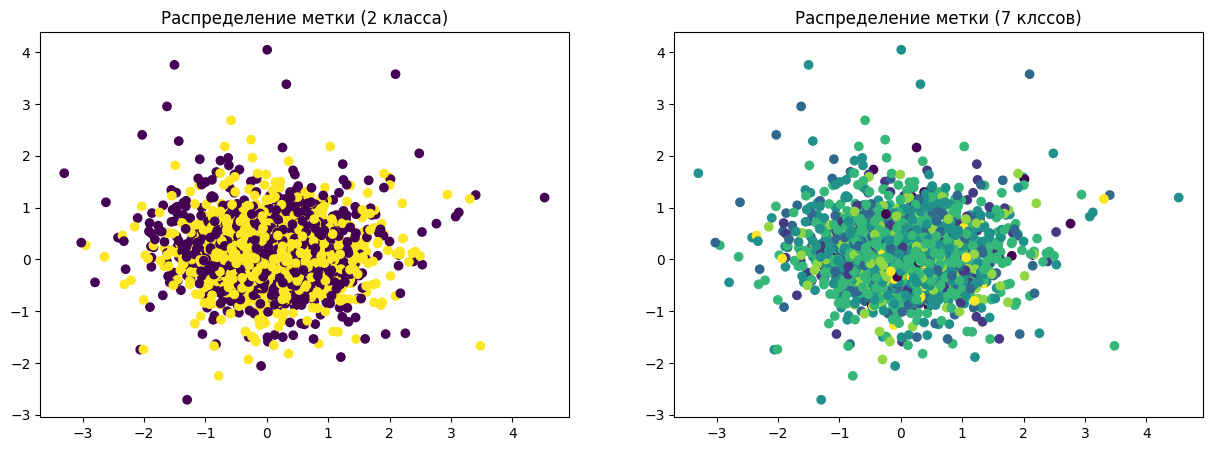

In [109]:
visualization_2D(audio, 'PCA', all_df.sentiment_2, all_df.sentiment_7)

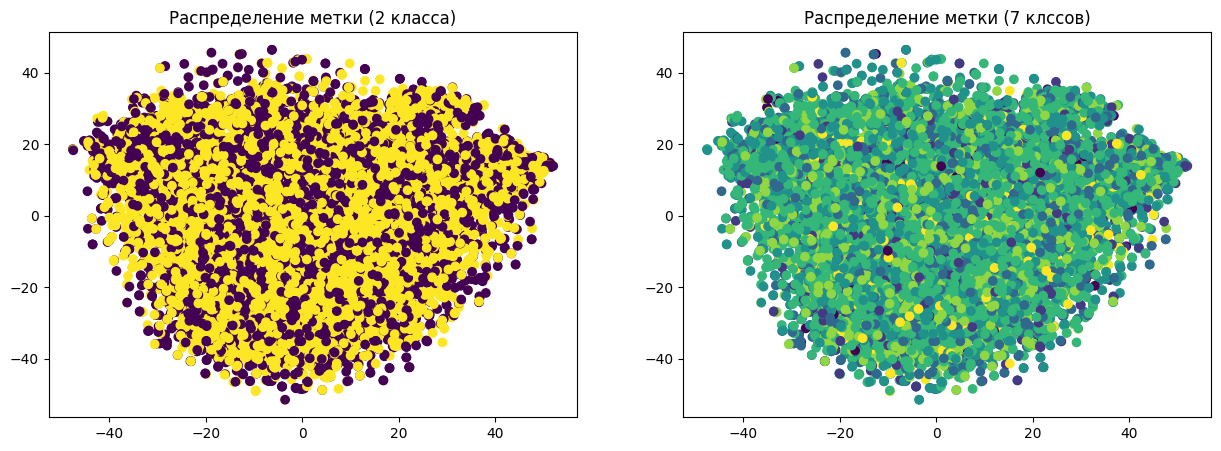

In [110]:
visualization_2D(audio, 'TSNE', all_df.sentiment_2, all_df.sentiment_7)

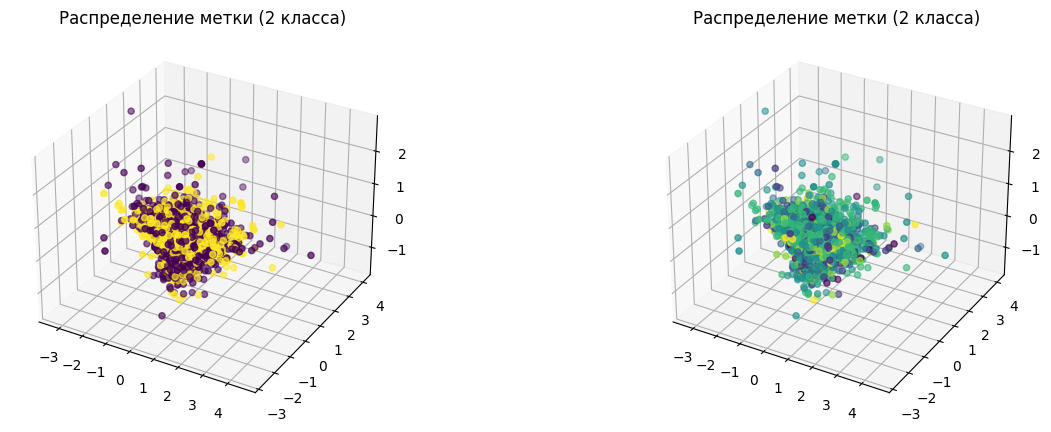

In [111]:
visualization_3D(audio, 'PCA', all_df.sentiment_2, all_df.sentiment_7)

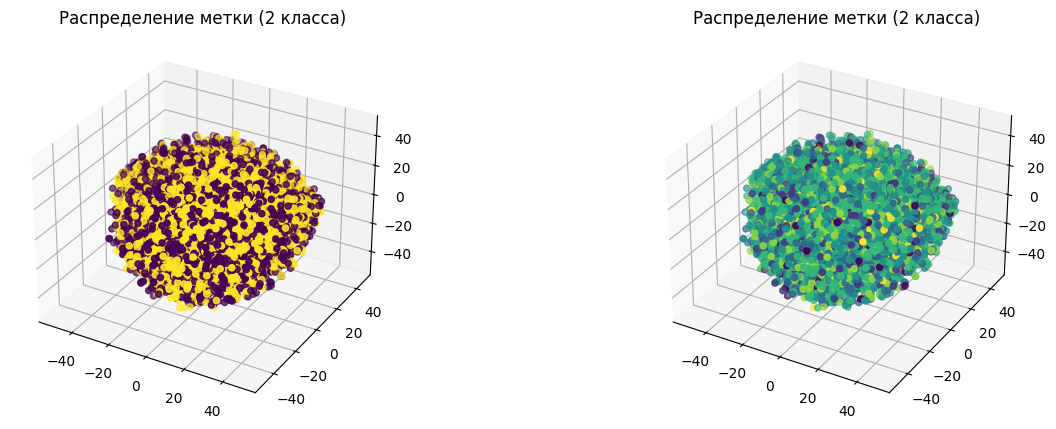

In [112]:
visualization_3D(audio, 'TSNE', all_df.sentiment_2, all_df.sentiment_7)

In [113]:
audio = load_file('saved/wav2vec_train.npy')

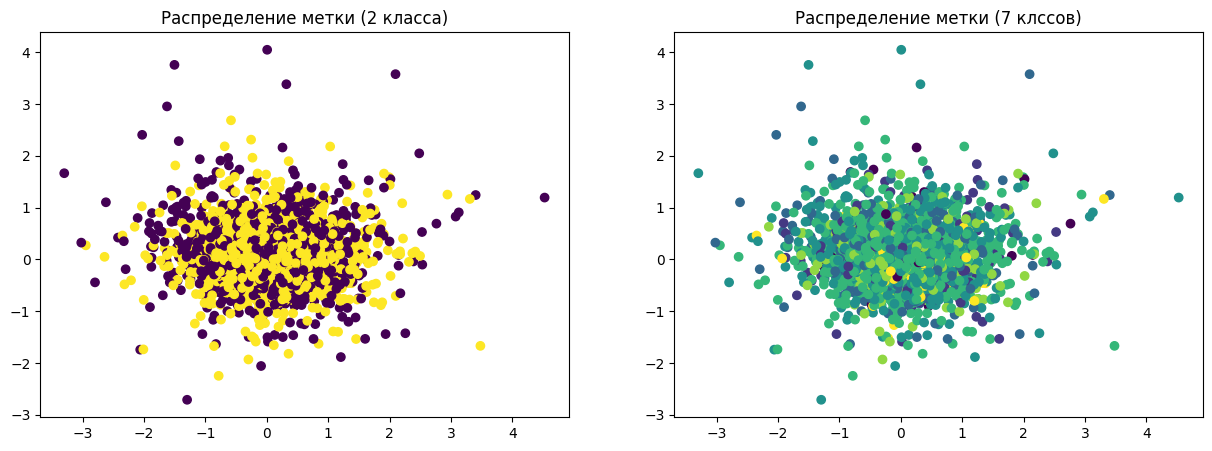

In [114]:
visualization_2D(audio, 'PCA', all_df.sentiment_2, all_df.sentiment_7)

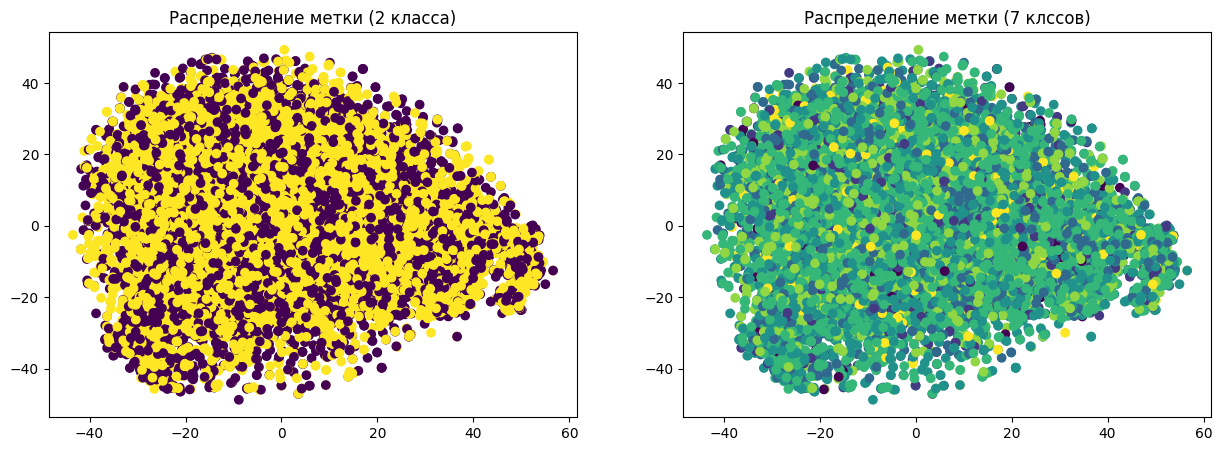

In [115]:
visualization_2D(audio, 'TSNE', all_df.sentiment_2, all_df.sentiment_7)

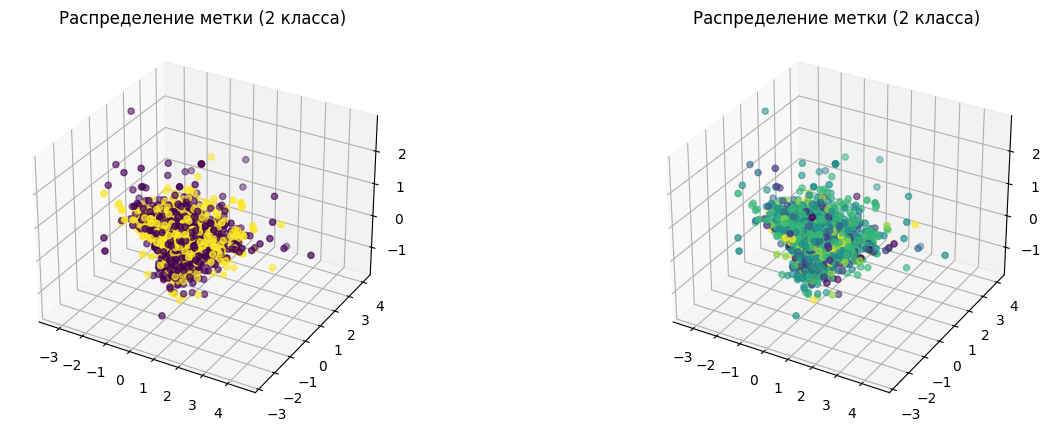

In [116]:
visualization_3D(audio, 'PCA', all_df.sentiment_2, all_df.sentiment_7)

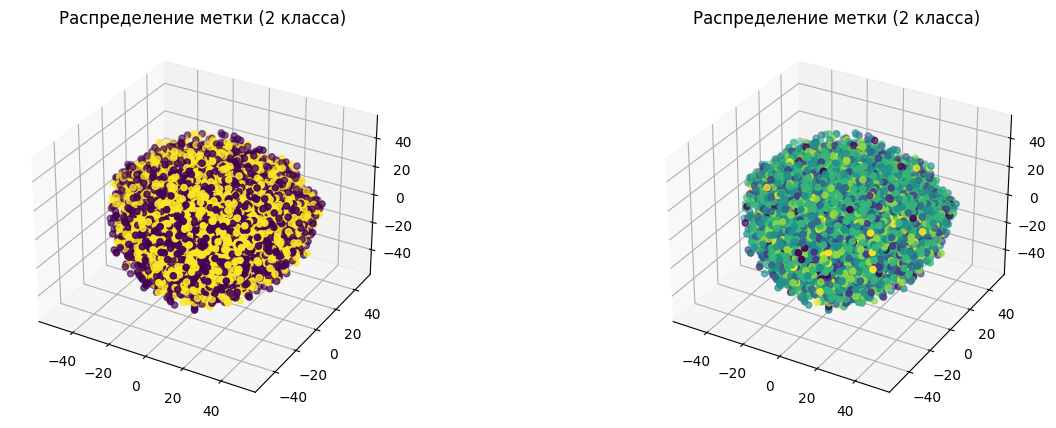

In [117]:
visualization_3D(audio, 'TSNE', all_df.sentiment_2, all_df.sentiment_7)

**Выводы:** `визулизация с помощью PCA и TSNE не выявила никакие паттерны в классах. Возможно, можно получить лучшее представление после fine-tuning`

### Spectrogram analysis

**Для** `каждого класса выберем случайное аудио и визуализируем мел-спектрограмму и mfcc.`

In [137]:
class_0 = all_df[all_df.sentiment_7 == 0].iloc[0, -3]
class_1 = all_df[all_df.sentiment_7 == 1].iloc[0, -3]
class_2 = all_df[all_df.sentiment_7 == 2].iloc[0, -3]
class_3 = all_df[all_df.sentiment_7 == 3].iloc[0, -3]
class_neg_1 = all_df[all_df.sentiment_7 == -1].iloc[0, -3]
class_neg_2 = all_df[all_df.sentiment_7 == -2].iloc[0, -3]
class_neg_3 = all_df[all_df.sentiment_7 == -3].iloc[0, -3]

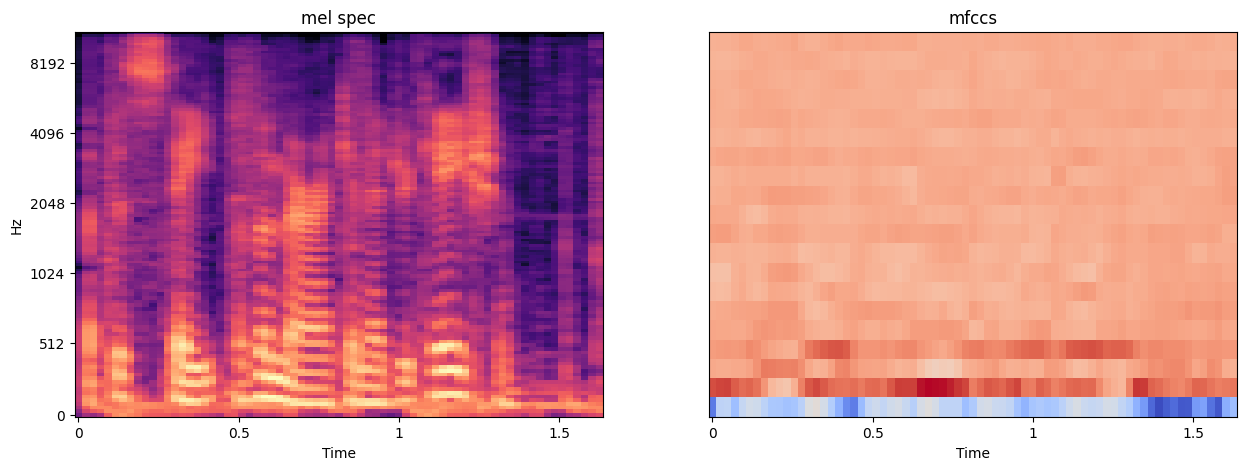

In [138]:
visualization_acustics(path_ + class_0)

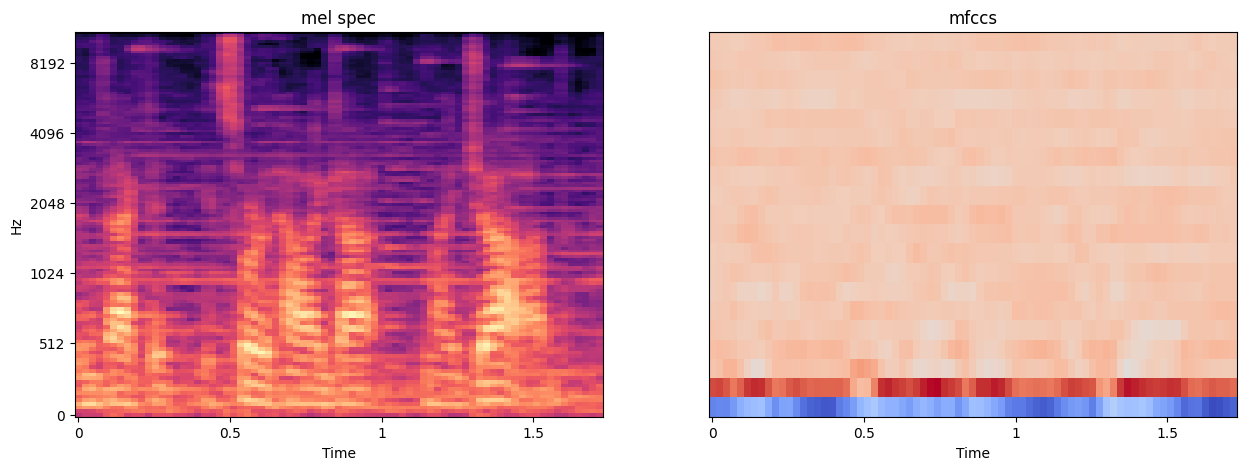

In [139]:
visualization_acustics(path_ + class_1)

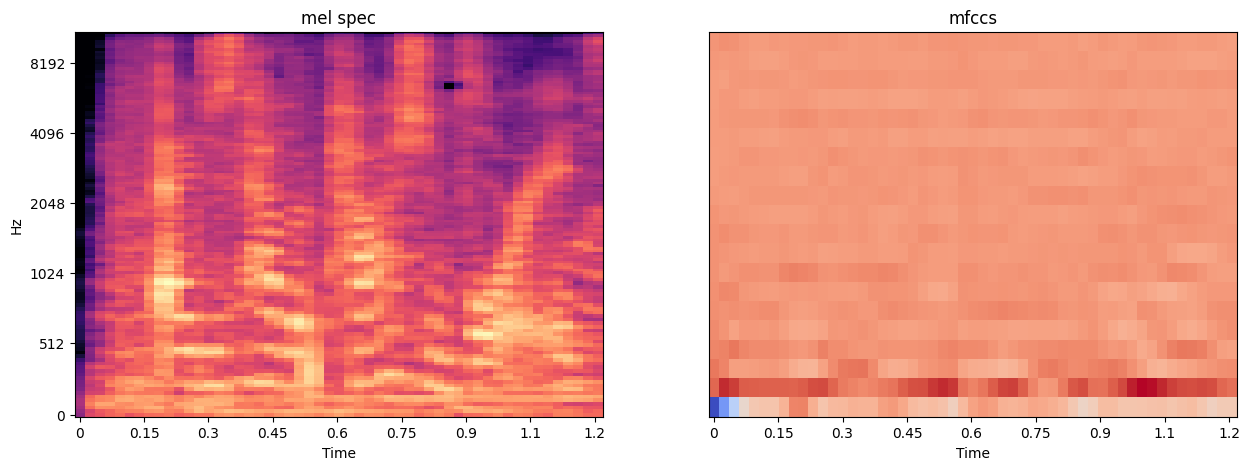

In [140]:
visualization_acustics(path_ + class_2)

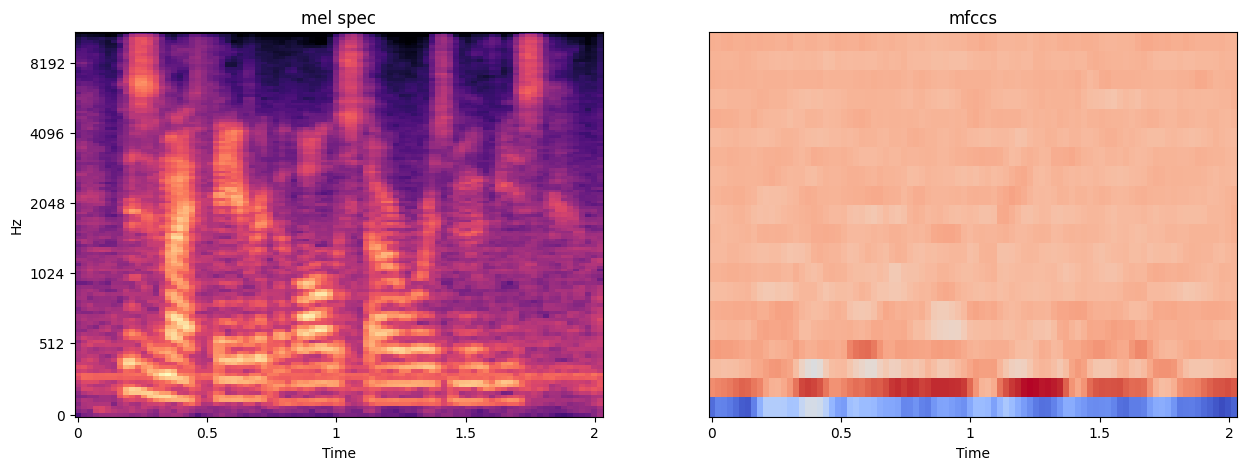

In [141]:
visualization_acustics(path_ + class_3)

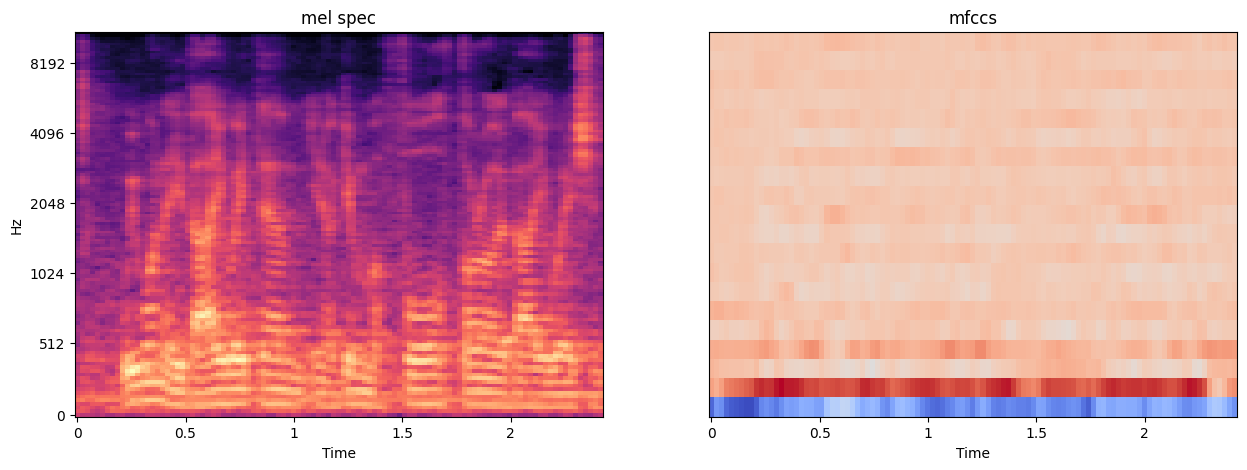

In [142]:
visualization_acustics(path_ + class_neg_1)

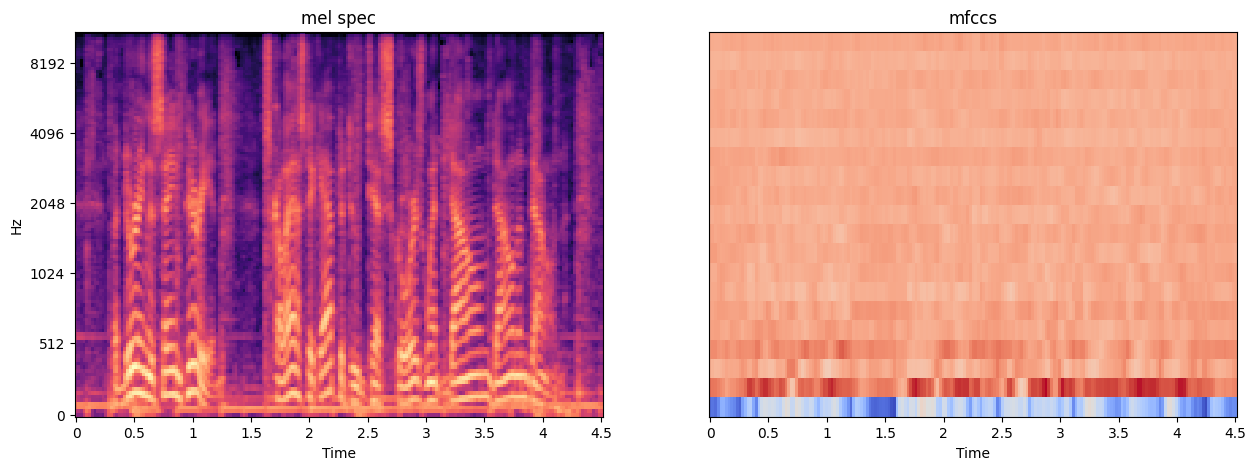

In [143]:
visualization_acustics(path_ + class_neg_2)

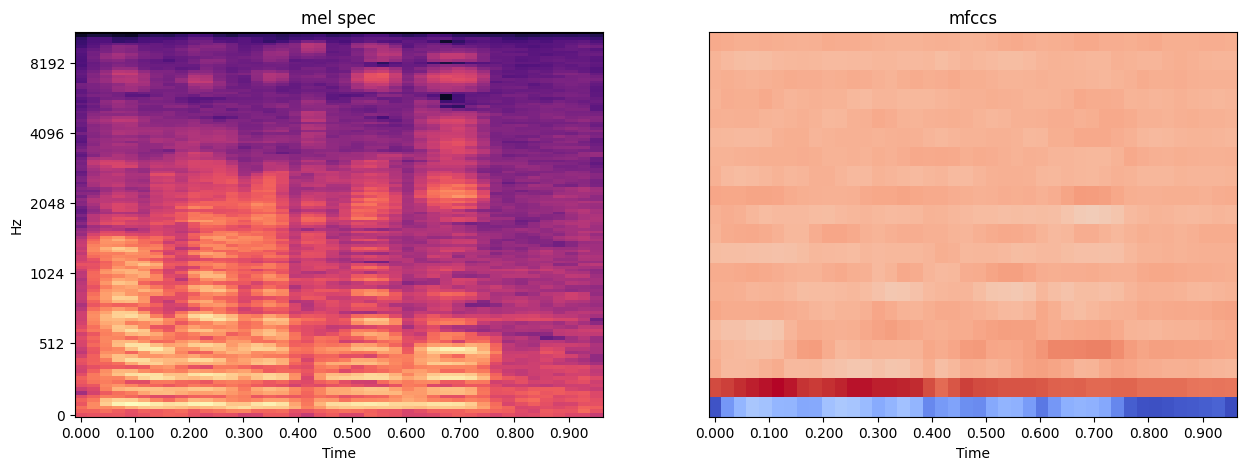

In [144]:
visualization_acustics(path_ + class_neg_3)

**Выводы:** `почти сразу в глаза бросаются интенсивность графиков в различных классах. Для большей информативности следует рассмотреть больше аудио, но интуиция подсказывает, аудио - хороший выбор для анализа тональности. Однако анализ статей по мультимодальному анализу показал, что наибольшую информативность дает именно текстовая информация. Один из аспектов - это большие предобученные языковые модели, которые существуют для текстовых корпусов. Возможно, использование wav2vec может изменить ситуацию.`